In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('data/fishpool_spot.xlsx')

df.drop(columns=['Week', 'EUR/kg'], inplace=True)
df['ln(NOK/kg)'] = np.log(df['NOK/kg'])
df['nan'] = np.nan

In [8]:
'''Fitting very basic - but good enough - "fourier" to the data. To both prices and log prices. Non-linear least squares.'''

def f(x, a0, b0, a1, theta):
    omega = 2*np.pi/52.1775
    y_hat = a0 + b0*x + a1*np.sin(omega*x + theta)  #a0 + b0*x handles linear trend in the data. a1*np.sin(omega*x + theta) handles the seasonality.
    #y_hat = a1*np.sin(omega*x + theta)
    return y_hat

from scipy.optimize import curve_fit
param_list = ['a0', 'b0', 'a1', 'theta']

params, cov = curve_fit(f, xdata = df.index, ydata = df['NOK/kg'], method='lm')
df['sinusoidal_NOK/kg'] = f(df.index, *params)
print('Curve fit on prices')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params)])

params_ln, cov = curve_fit(f, xdata = df.index, ydata = df['ln(NOK/kg)'], method='lm')
df['sinusoidal_ln(NOK/kg)'] = f(df.index, *params_ln)
print('Curve fit on log prices')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params_ln)])


Curve fit on prices
[('a0:', 16.81726250027343), ('b0:', 0.06828540564845421), ('a1:', 7.840064738046799), ('theta:', -6.340240868220679)]
Curve fit on log prices
[('a0:', 3.1645473347903437), ('b0:', 0.001338344551024466), ('a1:', 0.1333078863953622), ('theta:', -0.11269005100321834)]


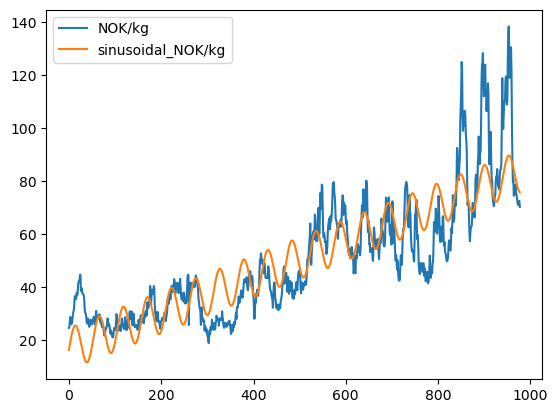

In [9]:
plt.plot(df.index,df['NOK/kg'], label='NOK/kg')
plt.plot(df.index,df['sinusoidal_NOK/kg'], label='sinusoidal_NOK/kg')
plt.legend()
plt.show()

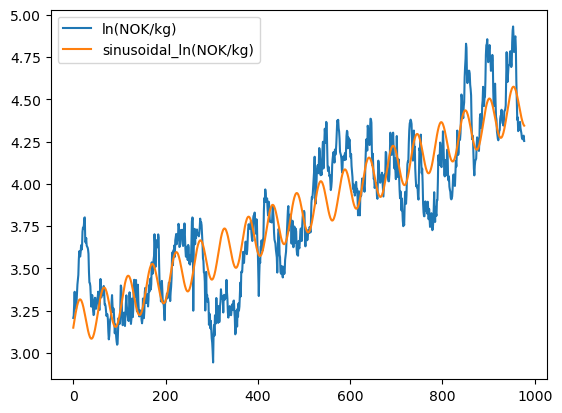

In [10]:
plt.plot(df.index,df['ln(NOK/kg)'], label='ln(NOK/kg)')
plt.plot(df.index,df['sinusoidal_ln(NOK/kg)'], label='sinusoidal_ln(NOK/kg)')
plt.legend()
plt.show()

In [14]:
"""Closely following Lucia&Schwartz. OU process reverting towards f. Rewritten to an AR(1) and parameters estimated through non-linear least squares."""
"""Here all parameters estimated concurrently, meaning also the curve already done above."""

def f(x, phi, a0, b0, a1, theta):
    omega = 2*np.pi/52.1775
    y_pred = phi*x[0] + a0 + b0*x[1] + a1*np.sin(omega*x[1] + theta) - phi*(a0 + b0*x[2] + a1*np.sin(omega*x[2] + theta))
    return y_pred

param_list = ['phi', 'a0', 'b0', 'a1', 'theta']

"""Prices"""
xdata = np.array([df['NOK/kg'][:-1], df.index[1:], df.index[:-1]])
params, cov = curve_fit(f, xdata = xdata, ydata = df['NOK/kg'][1:], method='lm')

df['luc_sch'] = np.append(np.nan, f(xdata, *params))
print('OU fit on prices:')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params)])

"""Log prices"""
xdata = np.array([df['ln(NOK/kg)'][:-1], df.index[1:], df.index[:-1]])
params_ln, cov = curve_fit(f, xdata = xdata, ydata = df['ln(NOK/kg)'][1:], method='lm')

df['luc_sch_ln'] = np.append(np.nan, f(xdata, *params_ln))
print('OU fit on log prices:')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params_ln)])

OU fit on prices:
[('phi:', 0.9538576843437799), ('a0:', 16.30105575227255), ('b0:', 0.06869365559581352), ('a1:', 7.766259150115258), ('theta:', -6.35858187801876)]
OU fit on log prices:
[('phi:', 0.9468980505979662), ('a0:', 3.1633980347325514), ('b0:', 0.001335053866759348), ('a1:', 0.13334822896237333), ('theta:', -0.12510781699068224)]


In [21]:
"""Phi is not equal to 1. The estimates for the sinusoidal are slightly different. I will redo the estimates, but now take f as given, as fist calculated above. In the end to choose whatever gives the smallest phi?
Redoing is also a good way to check that I did not do any implementation errors."""

'Phi is not equal to 1. The estimates for the sinusoidal are slightly different. I will redo the estimates, but now take f as given, as fist calculated above. In the end to choose whatever gives the smallest phi?\nRedoing is also a good way to check that I did not do any implementation errors.'

In [16]:
"""Taking the already done estimates for the sinusoidals"""

def f(x, phi):
    y_pred = phi*x[0] + x[1] - phi*x[2]
    return y_pred

param_list = ['phi']

"""Prices"""
xdata = np.array([df['NOK/kg'][:-1], df['sinusoidal_NOK/kg'][1:], df['sinusoidal_NOK/kg'][:-1]])
params, cov = curve_fit(f, xdata = xdata, ydata = df['NOK/kg'][1:], method='lm')

df['not_luc_sch'] = np.append(np.nan, f(xdata, *params))
print('OU fit on prices:')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params)])

"""Log prices"""
xdata = np.array([df['ln(NOK/kg)'][:-1], df['sinusoidal_ln(NOK/kg)'][1:], df['sinusoidal_ln(NOK/kg)'][:-1]])
params_ln, cov = curve_fit(f, xdata = xdata, ydata = df['ln(NOK/kg)'][1:], method='lm')

df['not_luc_sch_ln'] = np.append(np.nan, f(xdata, *params_ln))
print('OU fit on log prices:')
print([(symbol+':', estimation) for symbol, estimation in zip(param_list, params_ln)])

OU fit on prices:
[('phi:', 0.9538570713722283)]
OU fit on log prices:
[('phi:', 0.9468970815666442)]


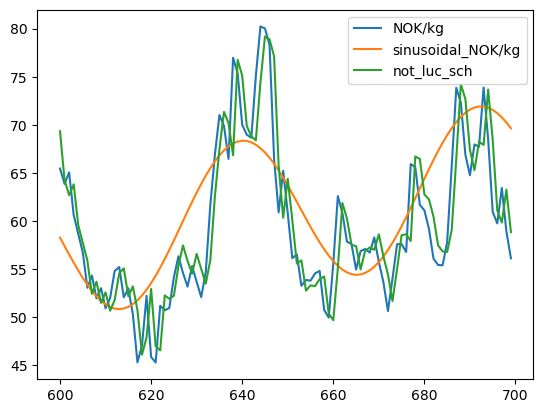

In [20]:
'Some visuals. Prices'
start_ix = 600
end_ix = 700
plt.plot(df.index[start_ix:end_ix],df['NOK/kg'][start_ix:end_ix], label='NOK/kg')
plt.plot(df.index[start_ix:end_ix],df['sinusoidal_NOK/kg'][start_ix:end_ix], label='sinusoidal_NOK/kg')
#plt.plot(df.index[start_ix:end_ix],df['luc_sch'][start_ix:end_ix], label='luc_sch')
plt.plot(df.index[start_ix:end_ix],df['not_luc_sch'][start_ix:end_ix], label='not_luc_sch')
plt.legend()
plt.show()

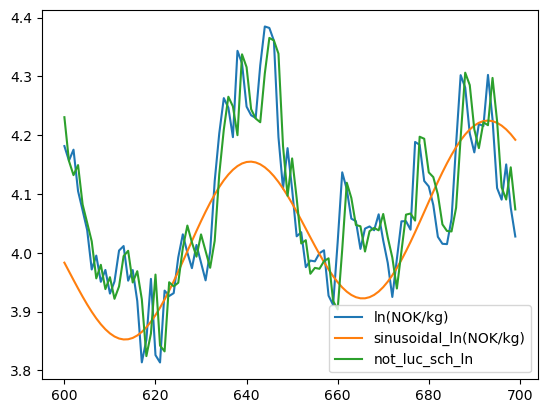

In [22]:
'Some visuals. Log prices'
start_ix = 600
end_ix = 700
plt.plot(df.index[start_ix:end_ix],df['ln(NOK/kg)'][start_ix:end_ix], label='ln(NOK/kg)')
plt.plot(df.index[start_ix:end_ix],df['sinusoidal_ln(NOK/kg)'][start_ix:end_ix], label='sinusoidal_ln(NOK/kg)')
#plt.plot(df.index[start_ix:end_ix],df['luc_sch_ln'][start_ix:end_ix], label='luc_sch_ln')
plt.plot(df.index[start_ix:end_ix],df['not_luc_sch_ln'][start_ix:end_ix], label='not_luc_sch_ln')
plt.legend()
plt.show()

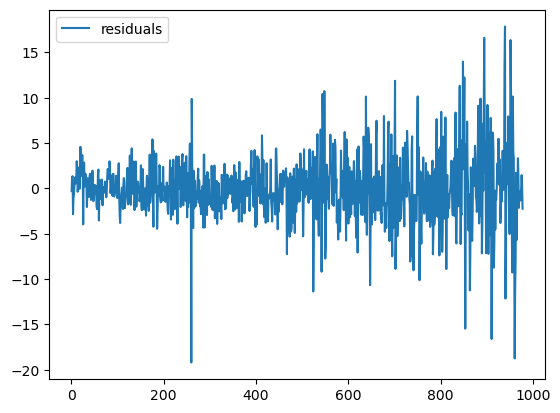

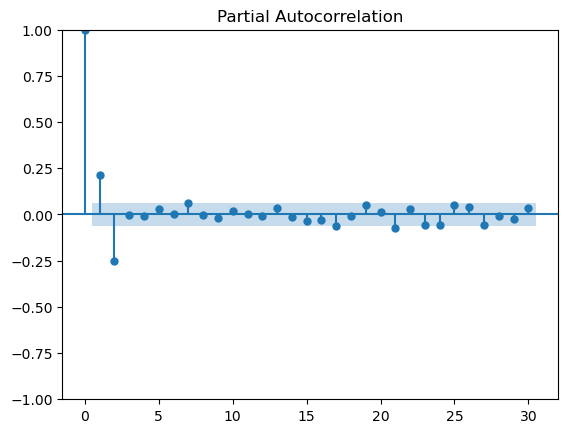

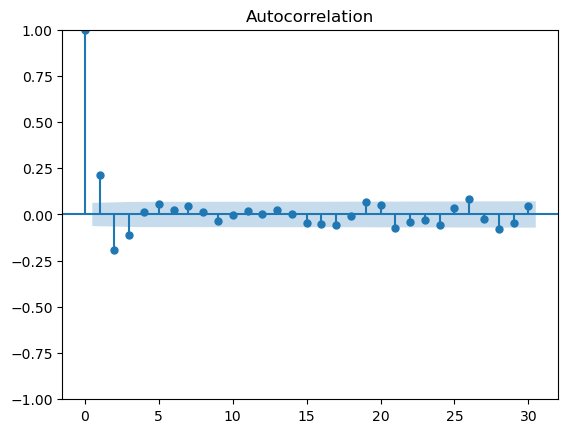

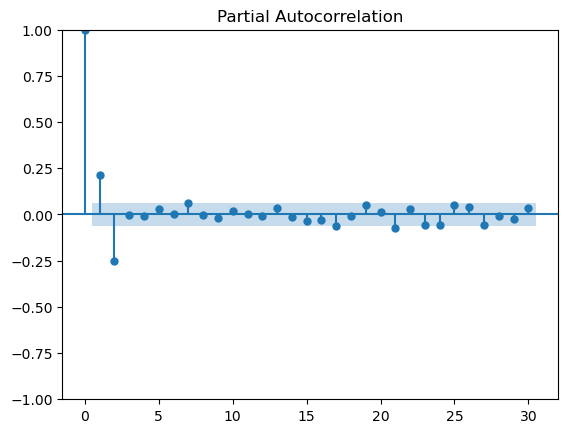

In [27]:
"""Residuals, prices"""
res = df['NOK/kg'][1:] - df['not_luc_sch'][1:]

plt.plot(df.index[1:],res, label='residuals')
plt.legend()
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(res, lags=30)
plot_pacf(res, lags=30, method='ywm')

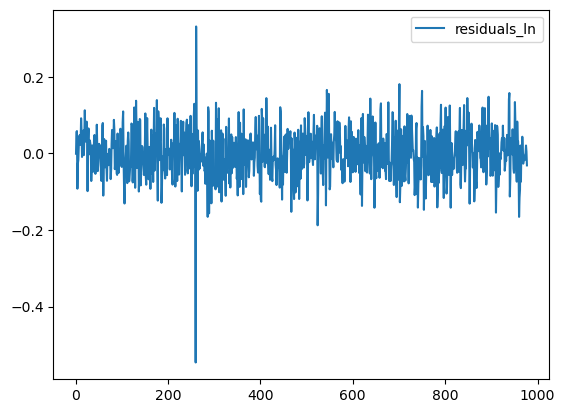

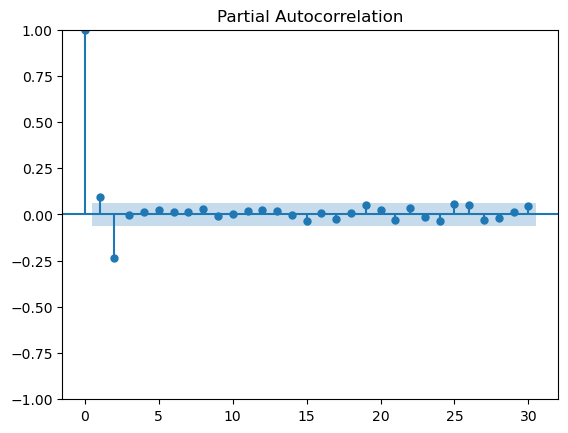

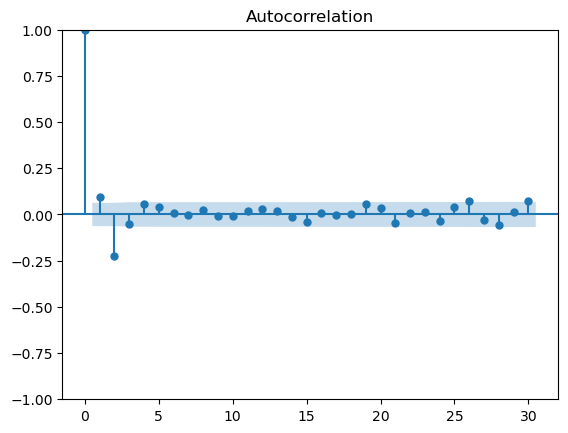

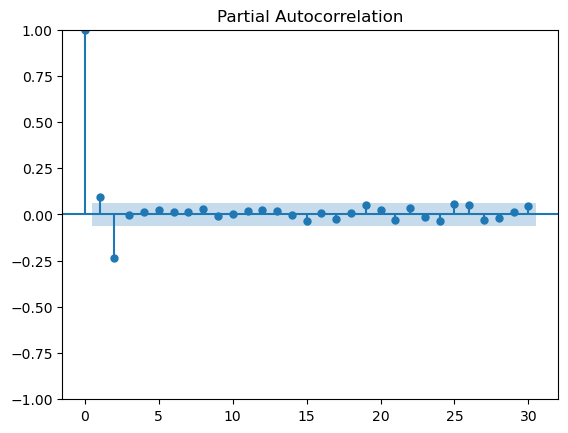

In [28]:
"""Residuals, log prices"""
res_ln = df['ln(NOK/kg)'][1:] - df['not_luc_sch_ln'][1:]

plt.plot(df.index[1:],res_ln, label='residuals_ln')
plt.legend()
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(res_ln, lags=30)
plot_pacf(res_ln, lags=30, method='ywm')

In [31]:
"""Finally find sigma and kappa for the OU process"""

"Prices"
se_of_reg = np.sqrt(np.sum(res**2)/(res.shape[0]-2))
sigma = se_of_reg

phi = params[0]
kappa = 1 - phi
print("Prices:")
print('  sigma:', sigma)
print('  kappa:', kappa)

"Log prices"
se_of_reg_ln = np.sqrt(np.sum(res_ln**2)/(res_ln.shape[0]-2))
sigma = se_of_reg_ln

phi = params_ln[0]
kappa = 1 - phi
print("Log prices:")
print('  sigma:', sigma)
print('  kappa:', kappa)

Prices:
  sigma: 3.6240202084430413
  kappa: 0.046142928627771695
Log prices:
  sigma: 0.06380086260236764
  kappa: 0.053102918433355795
